# Map-based Memory Validation

The idea of a location map is to remember sensory data. For our simple navigator, sensory data is like smell: our trees distributed through the environment diffuse scents indicating their identity. At a given point, the sense of smell detects a combination of data from nearby trees.

## A simple chemical sensor

The 'scent' $z$ of a tree should be detected proprotionately to the distance from a tree. I model the decay of the scent via a diffusion process. The model for diffusion (the physical process, not the algorithm) is based on the heat equation $u(x,t)$ is $$\frac{1}{2} \frac{\partial u}{\partial t} = \sum_i \frac{\partial^2 u}{\partial x_i^2} = \Delta u,$$ where $\Delta u$ is called the _Laplacian_. The heat equation is solved by
$$u(x, t) = \frac{c}{\sqrt{t^d}} \exp\left(-\frac{1}{2t} \|x - \mu\|^2\right),$$ 
where $d$ is the dimension of the space, $c$ is any constant, and $\mu$ is the intial point where diffusion starts.

Here $u(x,t)$ is the diffused quantity. For clarity, $x$ is the location of the sensor, and $\mu$ is the location of the source tree. At $u(x, 0) = c$, this is a point mass at $\mu$. Our interest is to choose a virtual time $t$ such that controls the spread of the tree's sense such that (a) trees can be sensed from a distance, and (b) trees are still distinct [note that $u(x, \infty) = 0$]. For simplicity, we set $c = \sqrt{t^d}$ so that $u(\mu, t) = 1$ for all $t$; that is, the sensor outputs the vector with all ones at the source. 

To choose $t$, we set a maximum distance $M$ and a target sensory value $a$ such that the diffused scent has magnitude $a$ at distance $M$. That is, $u(x, t_M) = a$ when $\|x - \mu\| = M$, which reduces to $$u(x, t) = \exp\left(-\frac{M^2}{2t}\right) = a \quad\quad\implies\quad\quad t_M = \frac{M^2}{2 \log({1}/{a})}.$$

Finally, given a set of trees at locations $\{\ell_i\}$ with scent embeddings $z_i$, a sensor at position $x$ will read the sum of the diffused scents
$$
z = \sum_i z_i \exp\left(-\frac{1}{2t_M} \| x - \ell_i\|^2\right) = KZ
$$
for the kernel matrix $K_ij = u_{i}(x_j, t_M)$ and scent matrix $Z$ with $z_i$ as the $i^{th}$ row.

This sensor is implemented by the following function, with some wrapping to handle batch sizes and the possibility of multiple sensors.

In [1]:
import torch
import math

def sense(self, source_locations: torch.Tensor, source_embeddings: torch.Tensor, sensor_positions: torch.Tensor, 
          M: float, a: float=0.1) -> torch.Tensor:
    # we expect source_locations to be a >2D tensor of shape (..., num_sources, dim)
    # we expect sensor_positions to be a >2D tensor of shape (..., num_sensors, dim) OR a 1D tensor of shape (..., dim)
    # we expect source_embeddings to be a >2D tensor of shape (..., num_sources, embed_dim)

    # special case for a single sensor
    single_sensor = sensor_positions.ndim < source_locations.ndim
    if single_sensor:
        sensor_positions = sensor_positions[..., None, :]
    
    assert source_locations.ndim == sensor_positions.ndim == source_embeddings.ndim
   
    # compute the virtual time
    t_M = M**2 / 2 / math.log(1/a)

    # compute the distance between the sensor and the source trees
    # This will yield a tensor of shape (..., num_sensors, num_sources)
    distances = torch.cdist(sensor_positions, source_locations)

    # now compute the kernel for each sensor-source pair as shape (..., num_sensors, num_sources)
    kernel = torch.exp(-0.5 * (distances).pow(2) / t_M)

    # now compute the embedding for each sensor as shape (..., num_sensors, embed_dim)
    if kernel.ndim == 2:
        embedding = torch.mm(kernel, source_embeddings)
    else:
        embedding = torch.bmm(kernel, source_embeddings)

    if single_sensor:
        embedding = embedding.squeeze(-2)

    return embedding

## A Memory to Remember Senses by Location

The purpose of the memory is to remember what would be sensed in a given location that was visited. In a continuous setting, we will never visit the exact same location twice, so we do not want a memory _per se_. Instead, we want an interpolator that can predict the expected sensory value well.

Suppose, then that our agent has visited a sequence of locations $\ell_t$, observing $z_t$ at each step, yielding a sequence of pairs $\{(\ell_t, z_t)\}$. Given a new location $\ell$, we want to estimate $\hat{z} = f(\ell)$ provided that for all $t$, $z_t \approx f(\ell_t)$. But _this is just a regression_! Our "memory" is not really a memory; it is a regression model trained from the dataset of visited points.

Our memory, then is a regression function $f$ trained on the visited points. However, we need a model that can be rapidly trained, because the memory needs to be immediately available from timestep to timestep. As a first approach, we can simply interpolate with an attention kernel.

In our case, our location estimates $\ell_t$ are generated by the agent and come with error, which we model as a Gaussian with diagonal covariance matrix (_i.e._, independent variation in each location dimension). Thus to each $\ell_t \in \mathbb{R}^d$ we associate a vector of deviations $\sigma_t \in \mathbb{R}^d$, and we want to regress $\hat{z} = f(\ell, \sigma)$. We can compute a location affinity kernel $k(\ell, \ell_t)$ between the inputs $\ell$ and $\sigma$ based on the $\sigma$-scaled distance as 
$$
\log k(\ell, \ell_t) = \quad-\frac{1}{2}\left\|\frac{\ell - \ell_t}{\sqrt{\sigma^2 + \sigma_t^2}}\right\|^2 
\quad-\sum_i \log | \sigma_i^2 + \sigma_{t,i}^2 | 
\quad-\frac{d}{2}\log 2\pi
$$
where logs make the relationships easier to see. Vector division is componentwise, and $k(\ell, \ell_t)$ is just the density function of a Gaussian $\mathcal{N}\left(\ell_t, \textrm{diag}\left(\sigma^2 + \sigma_t^2\right)\right)$ -- the variance combines the measurement error on both $\ell$ and $\ell_t$ and represents the variance of $\ell + \ell_t$.

Next, we can take a softmax over $\log k$ to get a set of affinity weights $w_t$ that will weight our dataset examples according to their closeness to the query point $\ell$, accounting for measurement error:
$$
w_t = \textrm{softmax} \left(\log k(\ell, \ell_t)\right) = \frac{k(\ell, \ell_t)}{\sum_s k(\ell, \ell_s)}
$$

From here, we can regress directly on the dataset to obtain the sensor estimate $\hat{z}$ by
$$
\hat{z} = \sum_t w_t z_t,
$$
which estimates the sensor output as a weighted average of the past sensor values.

In [2]:
import math

def read_memory(self, query_location: torch.Tensor, query_deviation: torch.Tensor, 
                memory_locations: torch.Tensor, memory_deviation: torch.Tensor, 
                memory_values: torch.Tensor) -> torch.Tensor:
    # we expect query_location to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect query_deviation to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect memory_locations to be a tensor of shape (..., num_keys, dim)
    # we expect memory_deviation to be a tensor of shape (..., num_keys, dim)
    # we expect memory_values to be a tensor of shape (..., num_keys, embed_dim)

    single_query = query_location.ndim < memory_locations.ndim
    if single_query:
        query_locations = query_location[..., None, :]
        query_deviations = query_deviation[..., None, :]
    
    assert query_locations.ndim == query_deviations.ndim == memory_locations.ndim == memory_deviation.ndim == memory_values.ndim

    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = query_deviation**2 + memory_deviation**2
    log_k = (
        - 0.5 * ((query_location - memory_locations).pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    # the location affinity weights have shape (..., num_queries, num_keys)
    w = torch.softmax(log_k, dim=-1)

    hat_z = torch.bmm(w, memory_values)

    if single_query:
        hat_z = hat_z.squeeze(-2)

    return hat_z

Now, you might notice that this kernel looks very similar to dot product attention, and then you might ask whether we could recast it to make use of efficient tools for handling long-context attention, such as flash attention. The answer is that _you could_, but you would be changing the topology of the location space in so doing, and you would have to work that change all the way through the math. We might do that later. For now, the clarity of keeping our space as $\mathbb{R}^d$ is preferable.

## Testing Basic Memory Reads

We will now check how well a memory that is populated with sensor data can do at building a model of a tree world. For this purpose, we'll allow our locations to be the "true" positions of our 2-D world space and avoid worrying about the agent learning a location representation for now; if the memory won't work for the the "truth", then it won't work for latent approximations of locations either. Also, we'll keep it simple by avoiding any compression of the sensor data; we'll just work with the sensor data in full dimension (which comes from a sentence embedding model here, specifically BAAI/bge-large-en-v1.5)

First we import the relevant elements of our simulation, and initialize a tree world.

In [3]:
from tree_world.simulation import TreeWorld, TreeWorldConfig, SimpleSensor

# create a world and memory
print("Creating world and memory...")
config = TreeWorldConfig()
world = TreeWorld.random_from_config(config)
config.embed_dim = 1024  # we'll use embeddings from text, and 

# print out the tree locations
print("--------------------------------")
for tree in world.trees:
    print(tree.tree_id, tree.name, tree.location.detach().cpu().numpy().tolist())
print("--------------------------------")

print("Creating sensor...")
sensor = SimpleSensor.from_config(config)

closest_distance, sense_value, closest_tree = sensor.sense(world, torch.zeros(2), None)

print("--------------------------------")
print(f"Testing sensor at (0, 0)")
print(f"Closest tree: {closest_tree.tree_id} ({closest_tree.name}) at {closest_distance.item():.2f}m")
print(f"Sense value: {sense_value}")
print(f"Tree embeddings: {closest_tree.embedding}")
print("--------------------------------")


Creating world and memory...
--------------------------------
Yvonne desert rose [-52.21006774902344, 94.84379577636719]
Olivia strychnine fruit [38.31069564819336, 240.04295349121094]
Ian pear [45.33448028564453, -128.17527770996094]
Bella strychnine fruit [21.759748458862305, 73.71565246582031]
Toby orange [-110.91397094726562, 24.072845458984375]
Maude plum [-232.325439453125, -12.055192947387695]
Sam banana [-22.02853775024414, 0.817585289478302]
Quincy mango [353.3446044921875, 221.08375549316406]
Julia orange [-119.72761535644531, -316.973388671875]
Albert orange [7.678021430969238, -39.31072998046875]
Florence plum [85.96174621582031, 261.0580749511719]
Rebecca manchineel [210.84666442871094, -99.25443267822266]
Barney desert rose [-57.2552490234375, -244.6267547607422]
Uma papaya [208.7955780029297, 169.6853485107422]
Nigel desert rose [-0.28244638442993164, -131.0449676513672]
Mary desert rose [-190.91172790527344, 77.46884155273438]
Jasmine orange [-172.56942749023438, -141.7

We can see that each tree has a name, a fruit type, and a 2-D coordinate in the world. The tree embeddings is generated under the hood by passing the name and tree type to our sentence embedder (see `tree_world.embeddings.embed_text_sentence_transformers` for the code).

Further, we have built a sensor and we can see that the embedding of the closest tree to the origin is similar to the value that we read from the sensor at the origin.

Let's find a way to see what the sensors can "see"

In [4]:
print("Preparing to make a grid of points...")

def make_2D_grid(points_per_axis: int, world_size: float=500.0):
    points = torch.linspace(-world_size, world_size, points_per_axis)
    return torch.cartesian_prod(points, points)

num_points = 100
print(f"Making a grid of points, {num_points} x {num_points}...")

grid = make_2D_grid(points_per_axis=num_points)

print(f"Made a grid of points: {grid.shape}; running sensor...")

_, sensor_values, _ = sensor.sense(world, grid, None)

print(f"sensor_values.shape: {sensor_values.shape}")

Preparing to make a grid of points...
Making a grid of points, 100 x 100...
Made a grid of points: torch.Size([10000, 2]); running sensor...
sensor_values.shape: torch.Size([10000, 1024])


In [5]:
%matplotlib inline

In [6]:
# generate a 3D embedding of the sensor values
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def make_rgb_model_from_sensor_values(values: torch.Tensor):

    sensor_np = values.cpu().numpy()

    N = sensor_np.shape[0]
    k = min(4000, N)                    # tune subset size
    idx = np.random.RandomState(42).choice(N, size=k, replace=False)    

    pca = PCA(n_components=3)
    rgb = pca.fit_transform(sensor_np[idx])
    return lambda x: pca.transform(x), rgb.min(axis=0), rgb.max(axis=0)


In [7]:
rgb_model, rgb_min, rgb_max = make_rgb_model_from_sensor_values(sensor_values)

In [8]:
def plot_sensor_field(values: torch.Tensor, key="Sensor Field"):
    rgb = rgb_model(values.cpu().numpy())

    # normalize the colors to be between 0 and 1 for display
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb = np.clip(rgb, 0, 1)

    H = W = int(math.sqrt(values.shape[0]))
    img = rgb.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (PCA colors)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig, ax

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


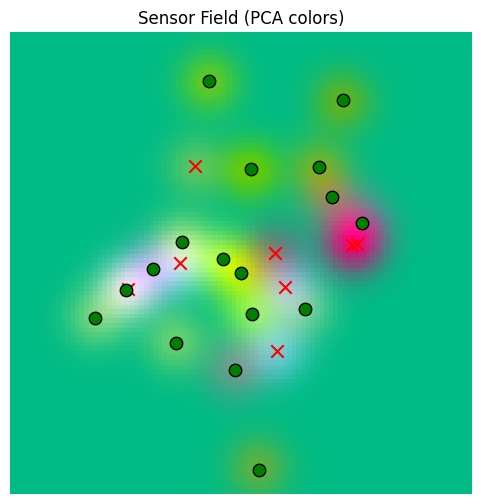

In [9]:
base_sensor_field, fig, ax = plot_sensor_field(sensor_values)

Now, let's create a memory and provide a way to show its contents.

In [10]:

from tree_world.models.memory import BidirectionalMemory

memory = BidirectionalMemory(
    location_dim=config.dim, 
    sensory_dim=config.sensory_embedding_dim, 
    embed_dim=config.embed_dim,   # note that if embed_dim=sensory_dim our memory does NOT compress or project inputs
    max_memory_size=1024,             # <-- beyond this size we will truncate the oldest memories
)


def plot_memory_field(train_locations: torch.Tensor, plot_locations: torch.Tensor, sd: float=1.0, match_threshold: float=None):
    # clear out the memory
    memory.reset()

    _, sensor_data, _ = sensor.sense(world, train_locations, None)

    # now we can call memory.write(locations, location_sds, senses) to write data
    train_location_sds = torch.empty_like(train_locations).fill_(sd)
    memory.write(train_locations, train_location_sds, sensor_data)

    # now we can call memory.read(locations, location_sds) to read data
    plot_location_sds = torch.empty_like(plot_locations).fill_(sd)
    read_data = memory.read(plot_locations[None, ...], plot_location_sds[None, ...], match_threshold=match_threshold)

    # plot the data
    plot_sensor_field(read_data.squeeze(0), key="Memory Field")

    return read_data.squeeze(0)

First, let's see how our memory does at just recalling the same data

Inactive mask: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


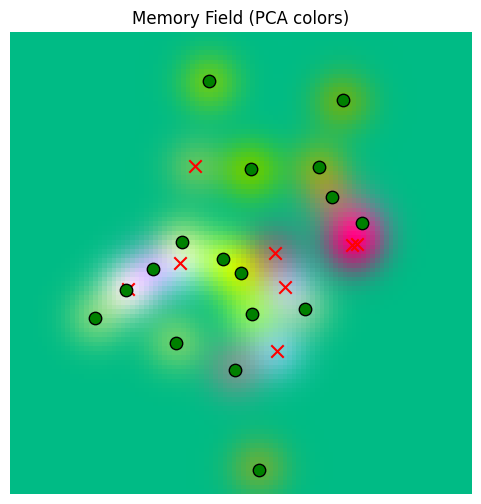

In [11]:
train_locations = make_2D_grid(points_per_axis=100)
read_data =plot_memory_field(train_locations, train_locations)

We can see here that the memory and the sensor yield plots appear virtually the same, so the memory is reading well. Just to be sure, we can compare them directly:

In [12]:
error = torch.norm(sensor_values - read_data, dim=-1)
print(f"Min Error: {error.min().item():.6f}")
print(f"Mean Error: {error.mean().item():.6f}")
print(f"Max Error: {error.max().item():.6f}")
print(f"Std Dev on Error: {error.std().item():.6f}")


Min Error: 0.000000
Mean Error: 0.000000
Max Error: 0.000000
Std Dev on Error: 0.000000


So the memory can read and write well. Now let's give it less data. Let's start with a smaller grid.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Inactive mask: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

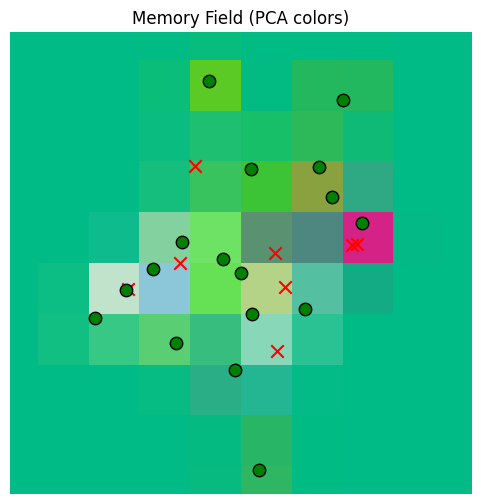

In [13]:
train_locations = make_2D_grid(points_per_axis=10)
plot_locations = make_2D_grid(points_per_axis=100)
smaller_grid_read_data = plot_memory_field(train_locations, plot_locations)

Our memory now provides a coarser approximation, as we expect. What if we provide random points, centered at the origin?

Inactive mask: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fals

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


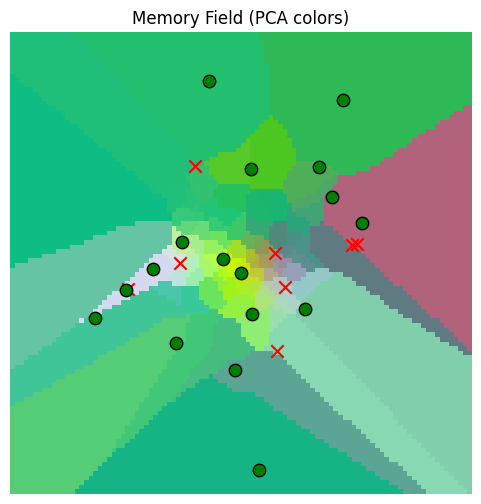

In [14]:
train_locations = torch.randn(100,2) * 100
plot_locations = make_2D_grid(points_per_axis=100)
gaussian_read_data = plot_memory_field(train_locations, plot_locations)

So the memory read quality is a good approximation near the origin, where it has more observations, but worse further away. This is all as we would expect. 

But still, do we really want to let points where we don't have good data be estimated from something far away? That doesn't make sense. That's why we snuck in the `match_threshold` parameter above, which lets us throw out approximants where there are no close points. You can look at `BidirectionalMemory.get_location_affinity()` for details, but basically we alter the read kernel to set $k(\ell, \ell_t) = 0$ if $\|\ell - \ell_t\| > \theta$ for the match threshold $\theta$.

Inactive mask: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


location_delta.min(dim=-1): [509.7016296386719, 502.58172607421875, 495.5654296875, 488.6571960449219, 481.8616638183594, 475.1836853027344, 468.6283264160156, 462.20074462890625, 455.90631103515625, 449.6666564941406, 440.49285888671875, 431.3605041503906, 422.27227783203125, 413.2310791015625, 404.24005126953125, 395.3026428222656, 386.422607421875, 377.6039123535156, 368.85101318359375, 360.1686706542969, 351.5621643066406, 343.0371398925781, 334.599853515625, 326.25714111328125, 318.01641845703125, 309.88580322265625, 301.8742370605469, 293.99139404296875, 286.2479553222656, 278.6555480957031, 271.2268371582031, 263.97564697265625, 256.9169921875, 250.06719970703125, 243.4438934326172, 237.06605529785156, 230.95401000976562, 225.12942504882812, 219.61517333984375, 214.43519592285156, 209.6142578125, 205.1776885986328, 201.1509246826172, 197.55902099609375, 194.4260711669922, 191.7745819091797, 189.62472534179688, 187.99375915527344, 186.89523315429688, 186.33856201171875, 186.32862

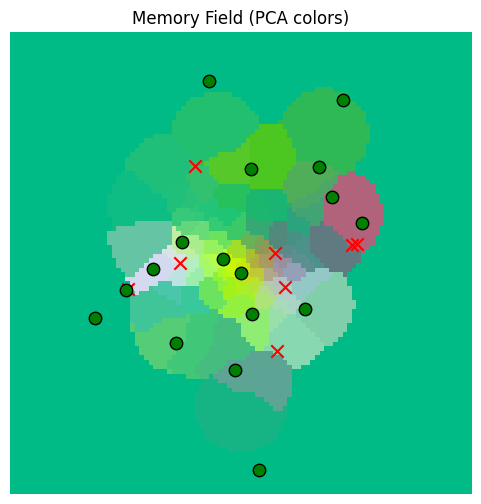

In [15]:
gaussian_read_data_thresholded = plot_memory_field(train_locations, plot_locations, match_threshold=100.0)

Much better now; we only make sensor estimates for values that are close.

## Classifying the Memory According to Drives

We are learning a location model that can predict senses from actions based on a memory. However, we also want to use that memory to search for where our agent can find fruit to satisfy its hunger. 

But to search the memory for things that satisfy hunger, we need to characterize sensory inputs in terms of the drives that they satisfy. So, we will build a _drive embedding classifier_ that takes classifies inputs across an array of mutually exclusive drives or motivations by computing
$$
s_m(z) = y_m \cdot z 
\quad\text{and evaluating}\quad 
\mathbb{P}(\text{$z$ satisfies $m$}) = \text{softmax}(s_m)
$$
which we train on the tree embeddings.

In [16]:
from tree_world.models.drives import train_drive_classifier

# we only want to train on the tree names (e.g. mango, pear, etc.), not the ids (Bob, Alice, etc.)
drive_classifier, drive_keys = train_drive_classifier(config, with_ids=False)
inverse_drive_keys = {v: k for k, v in drive_keys.items()}

print("--------------------------------")

tree_classifications = drive_classifier(torch.stack([tree.embedding for tree in world.trees]))
for tree, classification in zip(world.trees, tree_classifications):
    drive_idx = classification.argmax().item()
    drive = inverse_drive_keys[drive_idx]
    print(f"{tree.tree_id} -- {tree.name} -> {drive} ({classification[drive_idx].item()*100:.2f}%)")


Drive Embedding Classifier Loss (with fruit amount): 0.30425894260406494 MSE: 2.0401287201821106e-06 Accuracy: 100.00%
--------------------------------
Yvonne -- desert rose -> poison (89.70%)
Olivia -- strychnine fruit -> edible (63.82%)
Ian -- pear -> edible (99.98%)
Bella -- strychnine fruit -> edible (89.71%)
Toby -- orange -> edible (99.99%)
Maude -- plum -> edible (100.00%)
Sam -- banana -> edible (100.00%)
Quincy -- mango -> edible (100.00%)
Julia -- orange -> edible (100.00%)
Albert -- orange -> edible (99.96%)
Florence -- plum -> edible (99.99%)
Rebecca -- manchineel -> edible (53.43%)
Barney -- desert rose -> poison (74.71%)
Uma -- papaya -> edible (99.97%)
Nigel -- desert rose -> poison (83.74%)
Mary -- desert rose -> poison (73.21%)
Jasmine -- orange -> edible (100.00%)
Ann -- mango -> edible (99.98%)
Florence -- elderberry -> edible (99.99%)
Isaac -- papaya -> edible (99.99%)
Katherine -- plum -> edible (100.00%)
Jimmy -- banana -> edible (100.00%)
Sergei -- fig -> edible 

So our drive classifer correctly identifies the edible fruit.

Now let's visualize our sensor space in terms of drive satisfaction.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


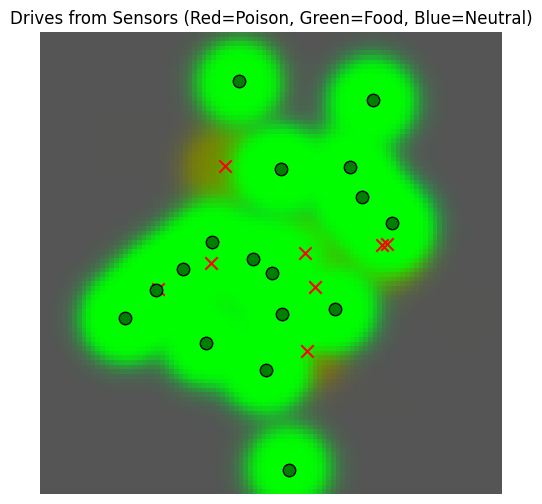

In [17]:


def plot_drive_field(values: torch.Tensor, key="Drives from Sensors", temperature=1.0):
    drive_by_location = drive_classifier(values)

    if temperature != 1.0:
        drive_by_location = drive_by_location ** (1.0 / temperature)
        drive_by_location = drive_by_location / drive_by_location.sum(dim=-1, keepdim=True)

    # we'll use a color scheme of red for poisonous, green for edible, and blue for unknown
    color_map = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=drive_by_location.dtype)
    color_by_location = torch.mm(drive_by_location, color_map).detach()

    H = W = int(math.sqrt(color_by_location.shape[0]))
    img = color_by_location.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (Red=Poison, Green=Food, Blue=Neutral)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig

drive_field, fig = plot_drive_field(sensor_values)


We see that the sensors yield predictions of edible only around the trees, as expected, with poisonous food detected wherever there are not too many non-poisonous trees close by. 

Now let's see what happens if we use our memory. We'll use the memory made from Gaussian reads near the origin.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


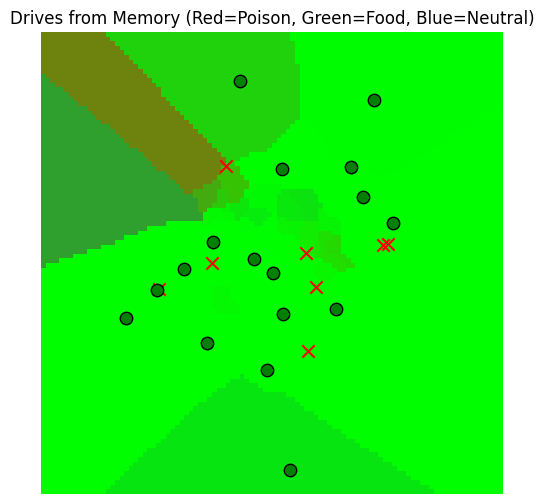

In [18]:
mem_drive_field, fig = plot_drive_field(gaussian_read_data, key="Drives from Memory")

Hmm, our memory is a little overactive. Maybe it's because of the way we chose to read based on the closest locations, even if they were far away in reality. To fix this, we should use the `match_threshold` parameter from above.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


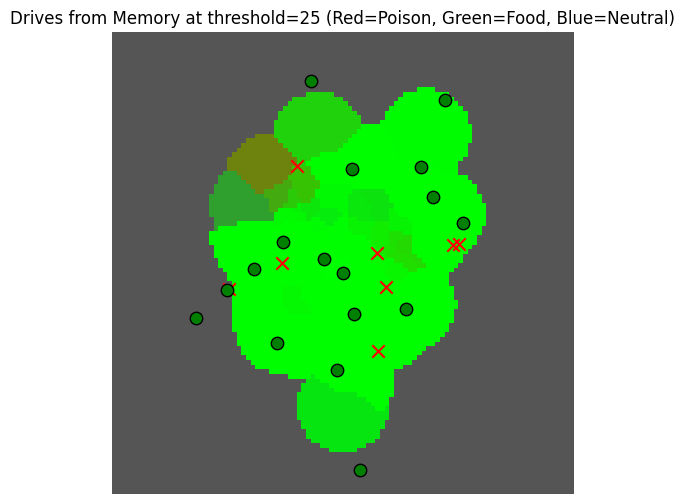

In [19]:
_, _ = plot_drive_field(gaussian_read_data_thresholded, key="Drives from Memory at threshold=25")


But this is still not really informative ... maybe it would be better to have a more peaked visualization to better observe the differences here.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/2340518492.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


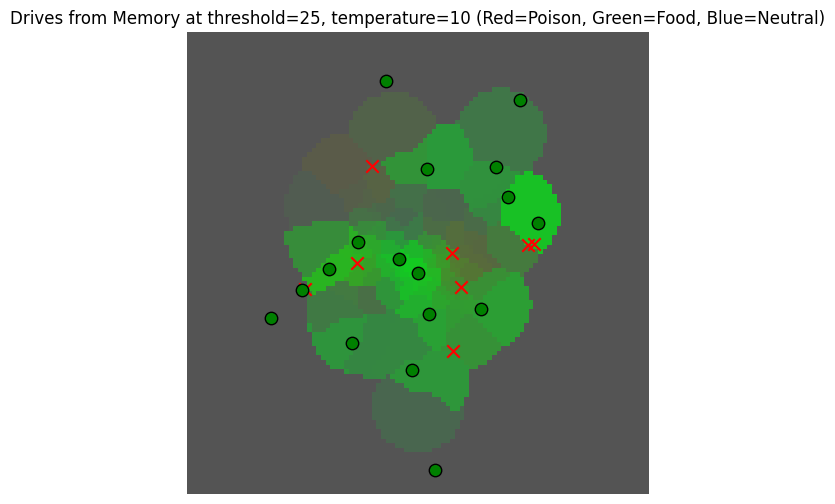

In [20]:
_, _ = plot_drive_field(gaussian_read_data_thresholded, key="Drives from Memory at threshold=25, temperature=10", temperature=10)

Now that we have a view of the memory based on drives, we can use it to find locations where there may be fruit.

## Searching the Memory for Information

We intend to use the memory three different ways:

- To read the expected sensory value of a location (as above)
- To verify an estimated location based on the sensory value (for learning the TEM VAE)
- To find desirable sensory locations based on a goal (to satisfy the agent's needs)

The first usage can be modeled as a regression over prior observations, as we did above. The second usage can ALSO be realized as a regression IF the sensor results are sufficiently distinctive. That is, so long as distinct locations ($\ell_t \neq \ell_s$) lead to distinct observations ($\implies z_t \neq z_s$), then we could apply the same regression-based read as before with the values swapped ($\hat{\ell} = g(z)$).

The third usage requires something different, however; in general, the basic drives of the organism will not be unique. So each non-poisonous fruit tree will satisfy hunger, and hence we no longer want a strict _function_ (one input -> one output). Instead, we want to _search_ the memory to provide multiple possible matches for a query value. 

Since our memory does not contain exact values for us to retrieve in any case, it will suffice to think of this search as a _sampling_ problem. That is, we want to use our observation dataset to learn a distribution that we can flexibly sample to get locations likely to satisfy our goal. 

Now, to specify what "meeting our goal" is. Let us suppose we have a scoring function $s(z)$ for sensor observations that assigns large positive values to matches, zero to ambiguous possible matches, and large negative numbers to irrelevant or mismatched data. 

So we want a conditional probability distribution $\mathbb{Q}$ over $\ell$ such that $$\hat{\ell} \sim \mathbb{Q}\left(\ell \,\vert\, s\right) \quad\implies\quad s\left(f(\hat{\ell})\right) >\!> 0$$
Which is to say that our samples are well aligned with our search key.

Now, for the simplest case, we can suppose there is a search key $y$, which will be a vector in the same space as our sensory output $z$, so that we can define the _affinity_ of $z$ to $y$ via dot products $s(z) = y \cdot z$. This gives us a straightforward way to compute the affinity of previously observed locations to our search; we just need to figure out $y$.

Because we already built a drive classifier for our sensors, we can use this classifier to get our affinity. For hunger, we can choose the sensor $s_{\text{hunger}}$ from the definition of the classifier above, which is determined by a search key $y_{\text{hunger}}$. Let's print it out.

In [21]:
y_hunger = drive_classifier.drive_embeddings.weight[drive_keys["edible"]].data
print(f"y_hunger = {y_hunger}")

value_of_apple =(world.tree_name_embeddings["apple"] * y_hunger).pow(2).sum().item()
print(f"value of apple for hunger = {value_of_apple} >> 0")


y_hunger = tensor([ 1.7354, -2.2180, -1.3357,  ..., -0.4808,  0.4981, -1.3969])
value of apple for hunger = 1.221765160560608 >> 0


So, we can find the edible fruit by sampling over our memory using $y_{\text{hunger}}$ as a search key.

But what does _sampling_ in this case mean? And how can we sample efficiently?

As a first approach, it is fairly simple to sample using a Gaussian mixture model (GMM). A GMM is just weighted sum of Gaussians:
$$
p_{\text{mix}}(z) \propto \sum_t w_t \,\mathcal{N}(z_t, \sigma^2)
$$
where $\mathcal{N}$ is just the Gaussian kernel and the weights are a softmax over the alignment scores,
$$
w_t = \text{softmax}_t \left(s(z_t)\right) = \text{softmax}_t \left(z_t \cdot y_{\text{hunger}}\right)
$$
To sample from this mixture, we first sample from $w_t$ as a multinomial, and then we use the resulting $z_t$ as the centroid of Gaussian with covariance $\sigma^2 I$.

In [22]:
def sample_conditional_gmm(memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_values: torch.Tensor, 
                           search_key: torch.Tensor, sigma_scale: float=25.0, num_samples: int=1, temperature: float=None):
    # memory_locations has shape (..., num_observations, dim)
    # memory_values has shape (..., num_observations, embed_dim)
    # search_key has shape (..., embed_dim)

    if temperature is None:
        temperature = memory_values.shape[-1]**(-0.5)

    # compute the alignment scores
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)
    w_t = torch.softmax(temperature * s_t, dim=-1)

    # sample from the mixture, result will be (..., num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, memory_locations.shape[-1])
    loc_mean = memory_locations.gather(dim=-2, index=t)
    loc_sd = memory_location_sds.gather(dim=-2, index=t)
    return loc_mean + torch.randn_like(loc_mean) * sigma_scale * loc_sd

# take a sample
hunger_sample = sample_conditional_gmm(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], num_samples=250,
    temperature=1.0
).squeeze(0)
hunger_sample_deviation = torch.norm(hunger_sample - hunger_sample.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample.shape} with deviation {hunger_sample_deviation}")

_, sensor_data_at_samples, _ = sensor.sense(world, hunger_sample, None)

drives_at_samples = drive_classifier(sensor_data_at_samples)

avg_hunger_at_samples = drives_at_samples[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples = drives_at_samples[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples}")
print(f"Minimum hunger at samples: {min_hunger_at_samples}")


Got a sample of shape torch.Size([250, 2]) with deviation 36.137672424316406
Average hunger at samples: 0.9996505379676819
Minimum hunger at samples: 0.9510611891746521


So we get a sample that has a high match with the hunger drive, as expected. But it looks like our samples are clustered too tightly! Where are our samples?

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


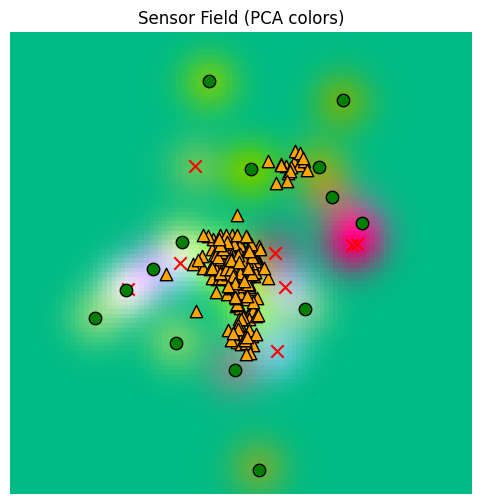

In [23]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

Well, these samples are ok, but they aren't really representative enough. We need to raise the temperature of our softmax. Here, I've set the default for `temperature` to be $1 / \sqrt{d}$, matching the kernel typically used for dot product attention. Let's use that instead of `temperature=1`.

In [24]:
# take a sample
hunger_sample_temperature = sample_conditional_gmm(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], num_samples=250,
    sigma_scale=25.0,
    temperature=None # <-- default; uses 1 / sqrt(d)
).squeeze(0)
hunger_sample_deviation = torch.norm(hunger_sample_temperature - hunger_sample_temperature.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample_temperature.shape} with deviation {hunger_sample_deviation}")

_, sensor_data_at_samples_temperature, _ = sensor.sense(world, hunger_sample_temperature, None)

drives_at_samples_temperature = drive_classifier(sensor_data_at_samples_temperature)

avg_hunger_at_samples_temperature = drives_at_samples_temperature[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_temperature = drives_at_samples_temperature[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_temperature}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_temperature}")

Got a sample of shape torch.Size([250, 2]) with deviation 55.33212661743164
Average hunger at samples: 0.9760362505912781
Minimum hunger at samples: 0.4134381413459778


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


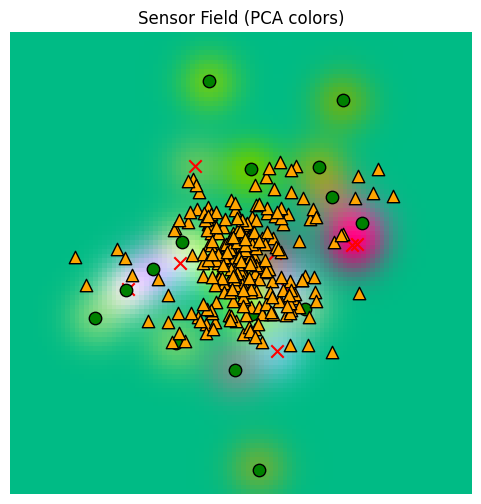

In [25]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample_temperature:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

Much better. Recall that the memory was populated from a Gaussian set of original locations, explaining why the samples are clustered about the origin and don't reach the edges of the space.

Note that our minimum hunger value has dropped significantly, though. We get more diverse samples, but they may have lower quality overall.

Yet we need to go further. For our agent, we don't just want to find a match for our drive anywhere; we want to preference matches that are close to the agent's current position.

We'll accomplish this by adjusting $w_t$ to take a given location $\ell$ into account:
$$
w_t = \textrm{softmax}\left(s_t \times \log k(\ell, \ell_t)\right)
$$

In [26]:
def sample_conditional_gmm_with_location(
    memory_locations: torch.Tensor, memory_location_sds: torch.Tensor, memory_values: torch.Tensor, 
    search_key: torch.Tensor, search_location: torch.Tensor, search_location_sd: torch.Tensor, 
    sigma_scale: float=1.0, num_samples: int=1, temperature: float=None
):
    # memory_locations has shape (..., num_observations, dim)
    # memory_values has shape (..., num_observations, embed_dim)
    # search_key has shape (..., embed_dim)

    if temperature is None:
        temperature = memory_values.shape[-1]**(-0.5)

    # compute the alignment scores
    s_t = torch.bmm(memory_values, search_key[..., None]).squeeze(-1)

    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = search_location_sd**2 + memory_location_sds**2
    log_k = (
        - 0.5 * ((search_location - memory_locations).pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    w_t = torch.softmax(temperature * s_t * log_k, dim=-1)

    # sample from the mixture, result will be (..., num_samples)
    t = torch.multinomial(w_t, num_samples=num_samples, replacement=True)
    t = t.unsqueeze(-1).repeat(1, 1, memory_locations.shape[-1])
    loc_mean = memory_locations.gather(dim=-2, index=t)
    loc_sd = memory_location_sds.gather(dim=-2, index=t)
    return loc_mean + torch.randn_like(loc_mean) * sigma_scale * loc_sd

# take a sample
location = torch.tensor([[100.0, 100.0]])
location_sd = torch.tensor([[25.0, 25.0]])
hunger_sample_with_location = sample_conditional_gmm_with_location(
    memory.memory_locations, memory.memory_location_sds, memory.memory_senses, y_hunger[None, ...], location, location_sd,
    num_samples=250, sigma_scale=25.0, temperature=None # <-- default; uses 1 / sqrt(d)
).squeeze(0)
hunger_sample_deviation_with_location = torch.norm(hunger_sample_with_location - hunger_sample_with_location.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {hunger_sample_with_location.shape} with deviation {hunger_sample_deviation_with_location}")

_, sensor_data_at_samples_with_location, _ = sensor.sense(world, hunger_sample_with_location, None)

drives_at_samples_with_location = drive_classifier(sensor_data_at_samples_with_location)

avg_hunger_at_samples_with_location = drives_at_samples_with_location[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_with_location = drives_at_samples_with_location[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_with_location}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_with_location}")

Got a sample of shape torch.Size([250, 2]) with deviation 68.05241394042969
Average hunger at samples: 0.9020190238952637
Minimum hunger at samples: 0.42160525918006897


Here we've biased the search to locations just up and to the right of the origin (marked with a blue square below). When this is done, we get a set of samples (yellow triangles) that is noticeably different from the free sampling above. 

Unlike when we were reading the memory above, we do NOT want to restrict match locations (`match_locations` above) when we are trying to find candidates to resolve drives. If we did that, we would exclude all faraway locations, and the only satisfaction might actually be far away. So we want to allow the memory search farther afield, if needed.

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


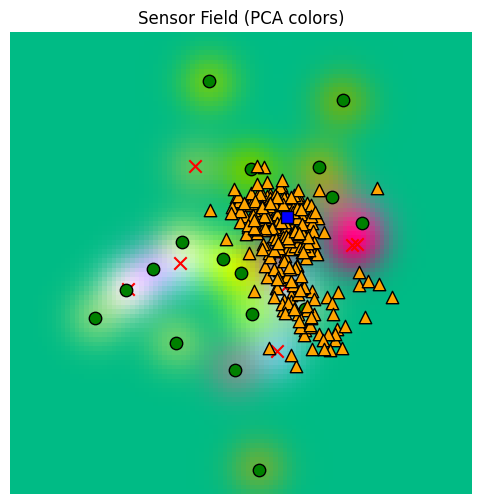

In [27]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in hunger_sample_with_location:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

ax.scatter(location[0, 0], location[0, 1], c="blue", marker="s", s=80, edgecolor="k")

This last sample function is also implemented, with a few more bells and whistles, on the `memory` object:

In [29]:
sample_hunger_from_memory = memory.sample(
    location, location_sd, y_hunger[None, ...], num_samples=250, sigma_scale=25.0, temperature=1.0 # <-- uses 1 / sqrt(d) here!!!
).squeeze( )

hunger_sample_from_memory_deviation = torch.norm(sample_hunger_from_memory - sample_hunger_from_memory.mean(dim=-1, keepdim=True), dim=-1).std()
print(f"Got a sample of shape {sample_hunger_from_memory.shape} with deviation {hunger_sample_from_memory_deviation}")

_, sensor_data_at_samples_from_memory, _ = sensor.sense(world, sample_hunger_from_memory, None)

drives_at_samples_from_memory = drive_classifier(sensor_data_at_samples_from_memory)

avg_hunger_at_samples_from_memory = drives_at_samples_from_memory[:, drive_keys["edible"]].mean().item()
min_hunger_at_samples_from_memory = drives_at_samples_from_memory[:, drive_keys["edible"]].min().item()

print(f"Average hunger at samples: {avg_hunger_at_samples_from_memory}")
print(f"Minimum hunger at samples: {min_hunger_at_samples_from_memory}")



Got a sample of shape torch.Size([250, 2]) with deviation 22.664121627807617
Average hunger at samples: 0.9277739524841309
Minimum hunger at samples: 0.819665789604187


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_83265/438877741.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


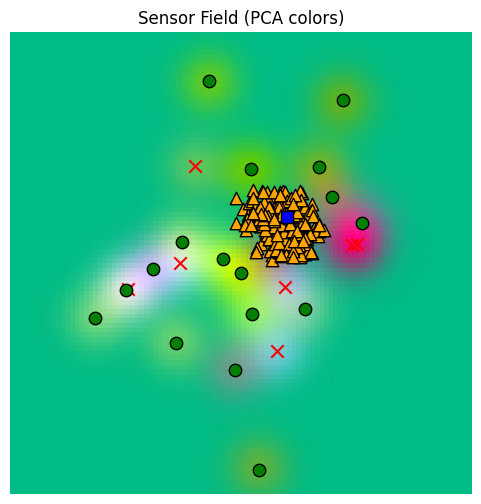

In [30]:
_, fig, ax = plot_sensor_field(sensor_values)

for sample in sample_hunger_from_memory:
    ax.scatter(sample[0], sample[1], c="orange", marker="^", s=80, edgecolor="k")

ax.scatter(location[0, 0], location[0, 1], c="blue", marker="s", s=80, edgecolor="k")